<a href="https://colab.research.google.com/github/Royal4224/ENM_5320/blob/main/Assignments/ENM_5320_Homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENM 5320 Homework 2 Report
Name: Roy Wang \
Date: 10 February 2025 \
Collaboraters: Shawn Koohy

In this assignment, we implemented the explicit Euler and Lax-Friedrich's schemes to numerically solve for solutions to the first order wave equation $u_{t} = -u_{x}$. We then learned a finite difference stencil using our dataset. This brief report will comment on the results from each part and compare performance across methods.
\
\
In part 2, we implemented explicit Euler and plotted the root mean square error of the numerically solved solutions to the true solutions. Through the plots of RMSE vs lambda and RMSE vs N, we can infer that that the error of explicit Euler grows unboundedly as either lambda or N increases. Moreover, this confirms that explicit Euler is unconditionally unstable.
\
\
In part 3, we implement the Lax-Friedrichs scheme and generate RMSE vs lambda plots. For lambda <= 1, we see that Lax Friedrichs is converges nicely for lambda -> 1 from below. In the second plot, we observe that lambda > 1 is the unstable regime for Lax-Friedrichs and the error quickly diverges to infinity.
\
\
In part 4, I attempted to learn a stencil based on the dataset. However, the performance was quite poor. Interestingly enough, only the $N_{sol}$th computed solution reflected the oscillatory behavior of the $N_{sol}$th true solution well, with the others not finding any significant oscillation at all. For example, only $u_5$ fits the 5th true solution well in the figure. I tried changing $N_{sol} = 7$, and then only the 7th true solution was fit well. There may be a simple error in my Pytorch code that is causing this. A limitation in my implementation of this part was a very slow training time despite only using 50 time and space points. I will try to troubleshoot this in future office hours and get better results as I become more familiar with Pytorch.

# Part 1: Create function to create dataset

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# calculation.to(device) if want to use GPU to speed up

# Global Variables
N_sol = 5
L = 2.0*np.pi  # Length of the domain
T = 4*np.pi   # Total time

def generate_u(N_sol, x, L, nx):
  two_k = torch.from_numpy(np.array([2**k for k in range(N_sol)]))
  return torch.sin(two_k[:, None] * np.pi * x / L).to(device).T

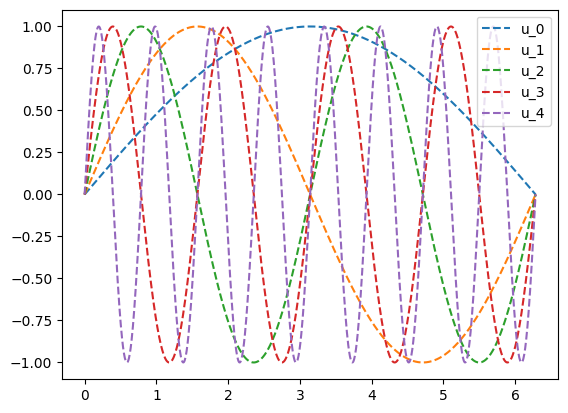

torch.Size([1000, 5])

In [109]:
nx = 1000
x = np.linspace(0, L, nx)
u = generate_u(N_sol, x, L, nx).detach().cpu()
u_exact = generate_u(N_sol, x-T, L, nx).detach().cpu()

for k in range(N_sol):
  u_k = u[:, k]
  plt.plot(x, u_k, '--', label = f'u_{k}')
  #plt.plot(x, u_exact[:, k], label = f'u_exact_{k}')
plt.legend()
plt.show()

u.shape

# Part 2: Implement Explicit Euler

In [110]:
# Parameters
#N_sol = 5
#L = 2.0*np.pi  # Length of the domain
#T = 4*np.pi   # Total time
#nx = 100  # Number of spatial points
#nt = 100  # Number of time steps - N
#dx = L / nx # h
#dt = T / nt # k
#lam = dt/dx
def explicit_euler(N_sol, nx, nt):
  # Discretization
  L = 2.0*np.pi  # Length of the domain
  T = 4*np.pi   # Total time
  dx = L / nx # h
  dt = T / nt # k
  x = np.linspace(0, L-dx, nx)

  I_nm1 = torch.diag(torch.ones(nx-1, dtype=torch.float64).to(device), diagonal=-1)
  I_n = torch.eye(nx).to(device)
  I_np1 = torch.diag(torch.ones(nx-1, dtype=torch.float64).to(device), diagonal=1)

  a = 0.5 * dt/dx
  A = a * I_nm1 + I_n - a * I_np1
  A[0][nx-1] = a
  A[nx-1][0] = -a

  powers = torch.from_numpy(np.array([2**k for k in range(N_sol)]))
  u = generate_u(N_sol, x, L, nx)
  #print(u.shape)
  u_exact = generate_u(N_sol, x-T, L, nx)

  for i in range(nt):
    u = torch.matmul(A, u)


  return torch.sqrt(torch.square(torch.norm(u - u_exact, dim = 0))).mean()




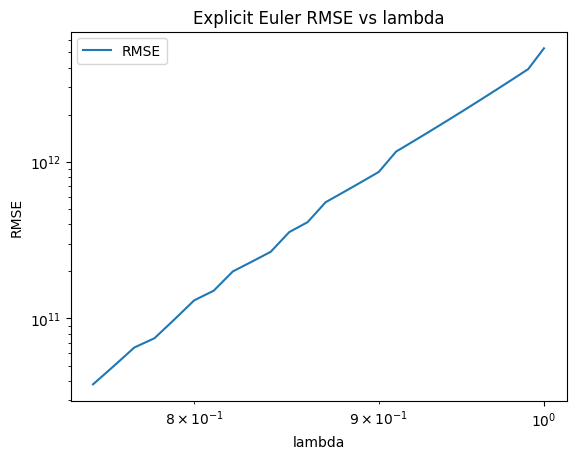

In [111]:
N_sol = 5
L = 2.0*np.pi  # Length of the domain
T = 4*np.pi   # Total time
nx = 50
dx = L / nx # h
lambda_vec = np.arange(0.75, 1.01, 0.01)

# RMSE vs lambda
RMSE = np.zeros_like(lambda_vec)
for i in range(len(lambda_vec)):
  dt = lambda_vec[i] * dx # k
  nt = int(T / dt)
  RMSE[i] = explicit_euler(N_sol, nx, nt)
  #print(RMSE[i])
plt.loglog(lambda_vec, RMSE, label = 'RMSE')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('Explicit Euler RMSE vs lambda')
plt.show()

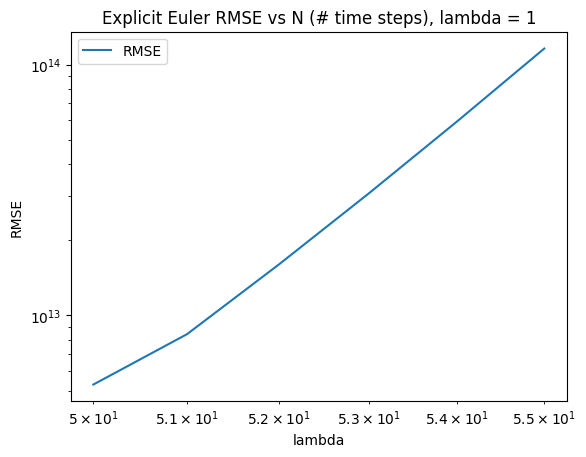

In [112]:
N_sol = 5
L = 2.0*np.pi  # Length of the domain
T = 4*np.pi   # Total time

# RMSE vs N, lambda = 1 fixed

nx_vec = [50, 51, 52, 53, 54, 55]
RMSE = np.zeros_like(nx_vec)
for i in range(len(nx_vec)):
  dx = L/nx_vec[i]
  dt = dx # k
  nt = int(T / dt)
  #print(nt)
  RMSE[i] = explicit_euler(N_sol, nx_vec[i], nt)
  #print(RMSE[i])
plt.loglog(nx_vec, RMSE, label = 'RMSE')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('Explicit Euler RMSE vs N (# time steps), lambda = 1')
plt.show()

# Part 3: Implement Lax-Friedrichs

In [113]:
def lax_friedrichs(N_sol, nx, nt):
  # Discretization
  L = 2.0*np.pi  # Length of the domain
  T = 4*np.pi   # Total time
  dx = L / nx # h
  dt = T / nt # k
  lam = dt/dx
  sigma = 0.5 * lam
  x = np.linspace(0, L-dx, nx)

  I_nm1 = torch.diag(torch.ones(nx-1, dtype=torch.float64).to(device), diagonal=-1)
  I_np1 = torch.diag(torch.ones(nx-1, dtype=torch.float64).to(device), diagonal=1)

  A = (0.5 + sigma) * I_nm1 + (0.5 - sigma) * I_np1
  A[0][nx-1] = 0.5 + sigma
  A[nx-1][0] = 0.5 - sigma

  powers = torch.from_numpy(np.array([2**k for k in range(N_sol)]))
  u = generate_u(N_sol, x, L, nx)
  #print(u.shape)
  u_exact = generate_u(N_sol, x-T, L, nx)

  for i in range(nt):
    u = torch.matmul(A, u)


  return torch.sqrt(torch.square(torch.norm(u - u_exact, dim = 0))).mean()


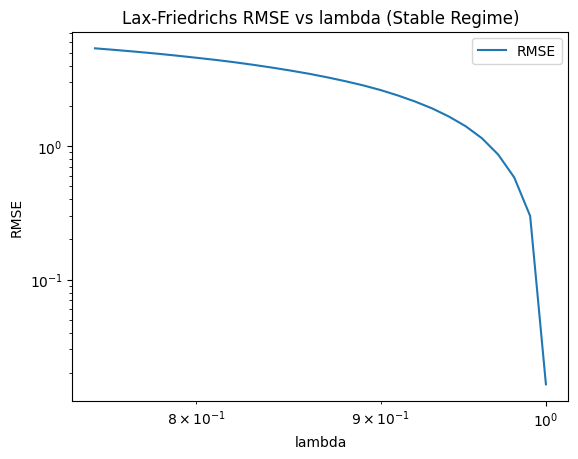

In [114]:
N_sol = 5
L = 2.0*np.pi  # Length of the domain
T = 4*np.pi   # Total time
nx = 1000
dx = L / nx # h
lambda_vec = np.arange(0.75, 1.01, 0.01)

# RMSE vs lambda for lambda <= 1
RMSE = np.zeros_like(lambda_vec)
for i in range(len(lambda_vec)):
  dt = lambda_vec[i] * dx # k
  nt = int(T / dt)
  RMSE[i] = lax_friedrichs(N_sol, nx, nt)
  #print(RMSE[i])
plt.loglog(lambda_vec, RMSE, label = 'RMSE')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('Lax-Friedrichs RMSE vs lambda (Stable Regime)')
plt.show()

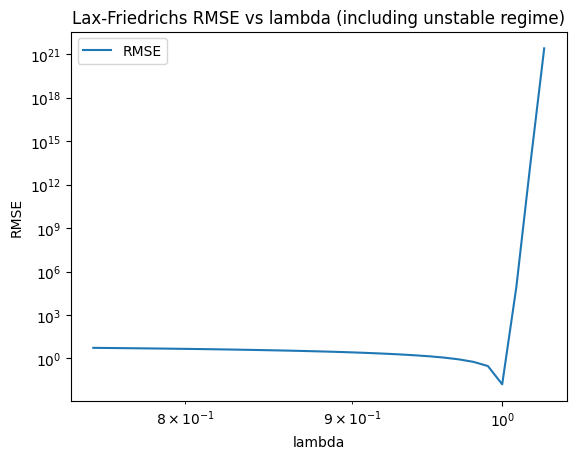

In [115]:
N_sol = 5
L = 2.0*np.pi  # Length of the domain
T = 4*np.pi   # Total time
nx = 1000
dx = L / nx # h
lambda_vec = np.arange(0.75, 1.03, 0.01)

# RMSE vs lambda (including unstable regime)
RMSE = np.zeros_like(lambda_vec)
for i in range(len(lambda_vec)):
  dt = lambda_vec[i] * dx # k
  nt = int(T / dt)
  RMSE[i] = lax_friedrichs(N_sol, nx, nt)
plt.loglog(lambda_vec, RMSE, label = 'RMSE')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('Lax-Friedrichs RMSE vs lambda (including unstable regime)')
plt.show()

# Part 4: Learn Data-Driven Stencil

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the model (in our case, its y = A*x + b)
class FiniteDifferenceOperator(nn.Module):
    def __init__(self,Nleft,Nright):
        super(FiniteDifferenceOperator, self).__init__()
        # Number of total nodes in finite difference stencils
        self.Nstencil = Nleft + Nright + 1
        self.Nleft = Nleft
        self.Nright = Nright

        # Initialize with random coefficients
        self.stencil = torch.nn.Parameter(torch.randn(self.Nstencil))
        #self.stencil = torch.nn.Parameter(torch.from_numpy((0.5/dx)*np.array([1,0,-1])))


    def forward(self, x):
        # Apply the finite difference stencil to the gridfunction x, assuming periodic BC
        # x has shape (nx, N_sol). number of nodes = x.shape[0]
        N_nodes = x.shape[0]
        #print(N_nodes)
        f_out = torch.zeros_like(x)
        for i in range(N_nodes):
          for jj in range(self.Nstencil):
            j = jj - self.Nleft
            j_withbc = (i+j)%(N_nodes-1)
            # single grid function -> system of grid function only changes this
            # to an operation on the ith node across all fns in system
            # (ie. each column of f)
            #print('stencil shape: ' + str(self.stencil.shape))
            #print('f_out shape: ' + str(f_out.shape))
            #print('x shape: ' + str(x.shape))
            f_out[i, :] += self.stencil[jj] * x[j_withbc, :]

        return f_out

In [105]:
# Parameters
N_sol = 5
L = 2.0*np.pi  # Length of the domain
T = 4 * np.pi   # Total time
nx = 50  # Number of spatial points
nt = 50  # Number of time steps

# Discretization
dx = L / nx
dt = T / nt
x = np.linspace(0, L, nx)
u = generate_u(N_sol, x, L, nx) # Initial condition
uexact = generate_u(N_sol, x-T, L, nx) # Exact solution
Dx = FiniteDifferenceOperator(1,1)  # Finite difference operator w a neighbor on either side

def uexact(x,t):
  return generate_u(N_sol, x-t, L, nx)

# Define the optimizer so that it optimizes over stencil parameters
optimizer = optim.Adam(Dx.parameters(), lr=0.01)

num_epochs = 1000

for epoch in range(num_epochs):
    loss = 0
    for n in range(nt):
        t = n*dt
        un = uexact(x,t)
        unp1 = uexact(x,t+dt)
        dudtn = (unp1-un)/dt
        dudt_learned = Dx(un)/dx
        loss += torch.mean((dudtn-dudt_learned)**2)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}', Dx.stencil.detach().numpy())

# Plot the results
# for n in range(nt):
#     u_new = np.zeros_like(u)
#     for i in range(nx):
#         u_new[i] = u[i] + ( 0.5 * dt / dx) * (u[(i+1) % (nx-1)] - u[(i-1) % (nx-1)])
#     for i in range(nx):
#         u[i] = u_new[i]
#     if n % 10 == 0:
#       tn = n*dt
#       uexact = np.sin(-2 * np.pi * (x-tn) / L)
#       plt.plot(x, u,'--',label='Numerical')
#       plt.plot(x, uexact, label='Exact')

Epoch [1/1000], Loss: 5636.5295 [-1.9084158 -0.1488642  0.7254144]
Epoch [11/1000], Loss: 4856.0381 [-1.8091011  -0.05034563  0.81193966]
Epoch [21/1000], Loss: 4265.9849 [-1.712748    0.04145391  0.8091999 ]
Epoch [31/1000], Loss: 3744.3311 [-1.6204982   0.12420241  0.7236276 ]
Epoch [41/1000], Loss: 3272.7892 [-1.5322086   0.19937544  0.6124035 ]
Epoch [51/1000], Loss: 2852.9270 [-1.4475458   0.26887488  0.49693266]
Epoch [61/1000], Loss: 2482.8522 [-1.3663414   0.33381742  0.384498  ]
Epoch [71/1000], Loss: 2159.1359 [-1.2885898   0.39456975  0.27737853]
Epoch [81/1000], Loss: 1877.9100 [-1.2143613   0.45108706  0.17598073]
Epoch [91/1000], Loss: 1635.2108 [-1.1437248   0.5032135   0.08019893]
Epoch [101/1000], Loss: 1427.1139 [-1.0767084   0.55084777 -0.01003835]
Epoch [111/1000], Loss: 1249.8189 [-1.0132921   0.5939891  -0.09464957]
Epoch [121/1000], Loss: 1099.7129 [-0.95341843  0.6327149  -0.17346504]
Epoch [131/1000], Loss: 973.4036 [-0.89700615  0.6671422  -0.24632728]
Epoch [

To approximate $u_t = - u_x$, we have
$\frac{u_j^{n + 1} - u_{j}}{dt} = \frac{Dx(u_j^n)}{dx}$ and thus \\
$u_{j}^{n + 1} = u_{j}^n + \frac{dt}{dx} (Dx(u_{j}^{n}))$

In [106]:
u = generate_u(N_sol, x, L, nx) # Initial condition
print(u.shape)
uexact = generate_u(N_sol, x-T, L, nx) # Exact solution

for k in range(nt):
  u = u + dt * (Dx(u) / dx)

torch.Size([50, 5])


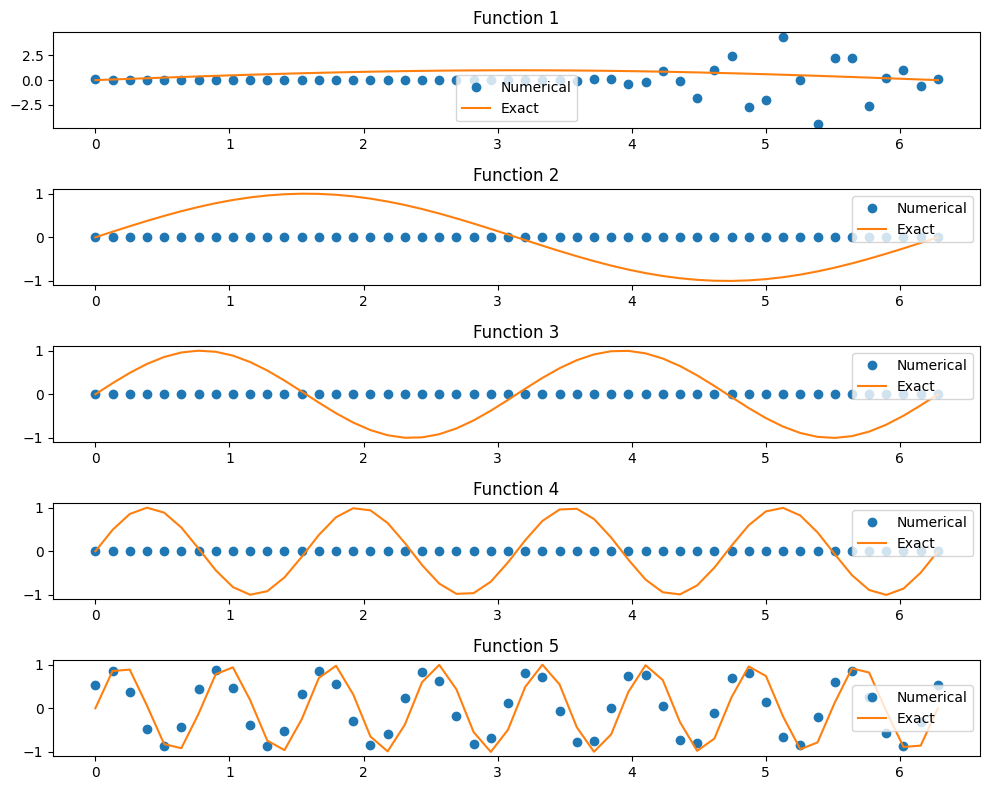

In [107]:
fig, axes = plt.subplots(N_sol, 1, figsize=(10, 8))
axes = axes.flatten()
for i in range(N_sol):
  u_i = u[:, i].detach().cpu()
  axes[i].plot(x, u_i, 'o', label='Numerical')
  axes[i].plot(x, uexact[:, i], '-', label='Exact')
  axes[i].set_title(f'Function {i+1}')
  axes[i].legend()

plt.tight_layout()
plt.show()